In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import datetime
import pickle

import ndpretty

import data_prep

In [2]:
ndpretty.default()

In [3]:
data = data_prep.load_beijing_data()


Loaded air quality data from 87 devices. No weather data for ['fangshan', 'miyun', 'yanqing', 'badaling', 'miyunshuiku', 'yufa', 'liulihe', '1042A', '1043A', '1044A', '1045A', '1046A', '1047A', '1048A', '1049A', '1050A', '1067A', '1068A', '1069A', '1070A', '1074A', '1075A', '1076A']


# PM2.5 GNN

In [4]:
data_path = "Previous work/PM2.5-GNN/data/"

know_air = np.load(data_path + "KnowAir.npy") # time × city × measure (17 features, 1 col for PM25)
cities = pd.read_table(data_path + "city.txt", delimiter=' ', header=None)
altitude = np.load(data_path + "altitude.npy")

with open(data_path + "city_dict.pkl", 'rb') as f:
    city_dict = pickle.load(f)

There aren't any NaN values in the data for PM2.5 GNN:

In [5]:
np.isnan(know_air).any()

False

For one city, multiple sensors seem to be grouped together.

In [6]:
city_dict['Beijing']

[['1001A', 116.366, 39.8673, 'Wanshouxigong'],
 ['1002A', 116.17, 40.2865, 'Dingling'],
 ['1003A', 116.434, 39.9522, 'Dongsi'],
 ['1004A', 116.434, 39.8745, 'Tiantan'],
 ['1005A', 116.473, 39.9716, 'Nongzhanguan'],
 ['1006A', 116.361, 39.9425, 'Guanyuan'],
 ['1007A', 116.315, 39.9934, 'Haidianquwanliu'],
 ['1008A', 116.72, 40.1438, 'Shunyixincheng'],
 ['1009A', 116.64399999999999, 40.3937, 'Huairouzhen'],
 ['1010A', 116.23, 40.1952, 'Changpingzhen'],
 ['1011A', 116.40700000000001, 40.0031, 'Aotizhongxin'],
 ['1012A', 116.225, 39.9279, 'Gucheng']]

The centroid of all sensor coordinates seems to be used as the cities computation location. However, the PM2.5 measurements within Beijing vary a lot. As we are focussing on Beijing, we probably shouldn't average over the whole city.

### Generate my own input data

#### `KnowAir.npy`

This file seems to be `time × city × measure` whereas `measure` contains 17 weather features and 1 column for PM2.5.

It includes no time steps, just the data. On the `time` dimension, it contains one entry every three hours.

In [7]:
data_start = pd.to_datetime("2015-01-01 00:00")
data_end = pd.to_datetime("2018-12-31 21:00")

know_air.shape[0], pd.Timedelta(data_end - data_start), (1460 * 24 + 21 + 3), (1460 * 24 + 21 + 3) / 3

(11688, Timedelta('1460 days 21:00:00'), 35064, 11688.0)

In [8]:
know_air

(11688×184×18) float64 ndarray


interactive(children=(Text(value='[:100, :100, 0]', description='Slice:', placeholder='e.g. [:100, :100, 0]'),…

In [9]:
rel_devices = [ 'qianmen', 'changping', 'daxing', 'shunyi', # Beijing
                '1056A', # Baoding
                # '1069A', # Langfang
                '1061A', # Zhangjiakou
                '1037A', # Tangshan
                ]

relevant = data.measurements
relevant = relevant[relevant['device_id'].isin(rel_devices)]

export_df = pd.DataFrame()
export_df['device_id'] = relevant['device_id']
export_df['time'] = relevant['time']
export_df['2m_temperature'] = relevant['temperature']
export_df['relative_humidity+950'] = relevant['humidity'] * 100
export_df['total_precipitation'] = relevant['precipIntensity']
export_df['wind_speed'] = relevant['windSpeed']
export_df['wind_direction'] = relevant['windBearing']
export_df['pm25'] = relevant['pm25']
export_df.index = relevant['time']

# drop all times at which at least one sensors has a NaN
missing_time = export_df[export_df.isnull().any(axis=1)]['time'].unique()
export_df = export_df[~export_df['time'].isin(missing_time)]

assert len(export_df) > 0, "No entries to export"

len(export_df)

116186

In [28]:
# transform from data frame to shape of KnowAir.npy
export_grouped = export_df.groupby('device_id').apply(pd.DataFrame.to_numpy)
export_devices = list(export_grouped.index)
my_know_air = list(map(lambda x: x[:,1:], export_grouped))

# time × city × measure
my_know_air = np.array(my_know_air)
my_know_air = my_know_air.swapaxes(0, 1)

In [12]:
np.save(data_path + 'KnowAir_import.npy', my_know_air)

#### `city.txt`

In [13]:
cities_export = pd.DataFrame({'device_id': export_devices}).merge(data.metadata, on='device_id')[['device_id', 'lon', 'lat']]

with open(data_path + 'city_import.txt', 'w') as city_f:
    city_f.write(cities_export.to_csv(sep=' ', header=False))

assert len(cities_export) == my_know_air.shape[1], "Mismatch between city.txt and know_air.npy"

In [14]:
cities_export

,device_id,lon,lat
0,1037A,118.1440,39.6430
1,1056A,115.5214,38.8707
2,1061A,114.9040,40.8725
3,changping,116.2300,40.2170
4,daxing,116.4040,39.7180
5,qianmen,116.3950,39.8990
6,shunyi,116.6550,40.1270


#### Dates

<AxesSubplot:xlabel='time'>

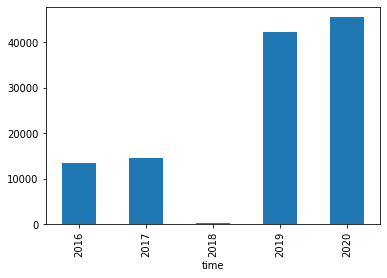

In [15]:
export_df.groupby(export_df['time'].dt.year).count()['time'].plot(kind='bar')

In [16]:
{
    'start_date': export_df['time'].min(),
    'end_date': export_df['time'].max()
}

{'start_date': Timestamp('2016-01-01 02:00:00'),
 'end_date': Timestamp('2020-12-31 23:00:00')}

## Results

Here we load the results from the GNN back to analyse them.

In [31]:
def transform_preds_back(time_npy, pred_npy, devices, data_start, melted=True):
    parsed_timestamps = pd.DataFrame(time_npy).applymap(pd.Timestamp.fromtimestamp)
    idx = np.where(parsed_timestamps[0] == data_start)[0][0] + 1  # there is an off-by-one error somewhere

    pred_index = pd.Index(parsed_timestamps[parsed_timestamps[0] == data_start].iloc[0], name='time')
    pred_df = pd.DataFrame(pred_npy[idx, :, :, 0], index=pred_index, columns=devices)

    if melted:
        return pred_df.melt(ignore_index=False, var_name='device_id', value_name='pm25')
    else:
        return pred_df

In [35]:
result_path = data_path + 'results/1_480/1/PM25_GNN/20210309210844/02/'

time_npy = np.load(result_path + 'time.npy')
pred_npy = np.load(result_path + 'predict.npy')
label_npy = np.load(result_path + 'label.npy')

#### Sanity check
Make sure that at the first (zeroth) timestamp of the prediction, we get back exactly the measurement. Otherwise, we made a mistake somewhere.

In [49]:
sample_timestamp = '2020-01-02 09:00:00'

y_pred = transform_preds_back(time_npy, pred_npy, export_devices, sample_timestamp, melted=True)
y_true = data.measurements[(data.measurements['time'] == sample_timestamp) & (data.measurements['device_id'].isin(rel_devices))]

for device in export_devices:
    true = y_true[(y_true['device_id'] == device) & (y_true['time'] == sample_timestamp)].iloc[0]['pm25']
    pred = y_pred[(y_pred['device_id'] == device) & (y_pred.index == sample_timestamp)].iloc[0]['pm25']
    assert true == pred, f"Found mismatch between measurement and prediction at measurement step for '{device}' at {sample_timestamp} -> {true} != {pred}"